# ASAXS data reduction

some script description

## Libraries

In [1]:
import pandas as pd
import os
import csv
import time

import numpy as np
from scipy import optimize
import scipy.constants as con
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap

import fabio
import pyFAI
from pyFAI.detectors import Pilatus1M

## Fuctions

In [2]:
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
          
         'alpha': ((0.0, 0.0, 0.0),
                   (1.0, 0.7, 0.7))
         }
red_alpha = LinearSegmentedColormap('red_alpha', cdict)
plt.register_cmap(cmap=red_alpha)

## Read the basic data

In [7]:
# give the directory
data_dir = 'files\Data_for_ASAXS'
# name if data file ontaining all nessesary information
metaFileName = 'Data_for_ASAXS_ASCII_out_changed_test.txt'

#read the meta file
path_to_metaFile = data_dir + os.sep + metaFileName
metaFrame = pd.read_csv(path_to_metaFile, sep='\,',index_col=0,engine='python')

# Define divice identifiers
sampleName = 'SampleName'
monitorDiode = 'Keysight4'
monitorDeviation = 'Keysight4:StandardDeviation'
transmissionDiode = 'Keysight1'
transmissionDeviation = 'Keysight1:StandardDeviation'
acquisitionTime = 'PilatusAcqTime'


In [39]:
tiffName = metaFrame['Pilatus_filename'][0].split('/')[-1]
tiffPath = data_dir + os.sep + tiffName
energy = metaFrame['Energy'][0]
print(tiffPath, energy)

files\Data_for_ASAXS\pilatus_2020kw29tg14_00378.tif 7000.002692


## Data Handling

In [27]:
for element in metaFrame.index:
    # read the image
    tiffName = metaFrame['Pilatus_filename'][element].split('/')[-1]
    tiffPath = data_dir + os.sep + tiffName
    image_object = fabio.open(tiffPath)
    image = image_object.data
    # print(image_object.header)
    
    # read values
    monitorI = metaFrame[monitorDiode][element]
    transmI = metaFrame[transmissionDiode][element]
    monitorI_dev = metaFrame[monitorDeviation][element]
    transmI_dev = metaFrame[transmissionDeviation][element]
    empty_monitorI = metaFrame[monitorDiode][metaFrame['Empty_Index'][element]]
    empty_transmI = metaFrame[transmissionDiode][metaFrame['Empty_Index'][element]]
    acqTime = metaFrame[acquisitionTime][element]
    
    # calculate transmission
    image_transmission = (transmI/monitorI)/(empty_transmI/empty_monitorI)
    image_transmission_deviation = image_transmission * (monitorI_dev/monitorI + transmI_dev/transmI)
    print(tiffName,'measured',acqTime,'sec with transmission:' , image_transmission, '+/-',image_transmission_deviation)
    
    # handle images
    image = image / monitorI / acqTime / image_transmission
    
    #fig, ax = plt.subplots()
    #ax.imshow(image, norm=LogNorm())

pilatus_2020kw29tg14_00378.tif measured 600 sec with transmission: 1.0 +/- 0.002322898396343198
pilatus_2020kw29tg14_00379.tif measured 300 sec with transmission: 0.935972710692432 +/- 0.0023710625470877915
pilatus_2020kw29tg14_00380.tif measured 10 sec with transmission: 0.5822358051283638 +/- 0.00024082481542033683
pilatus_2020kw29tg14_00381.tif measured 600 sec with transmission: 0.6333670992319331 +/- 0.006531416362882512
pilatus_2020kw29tg14_00382.tif measured 600 sec with transmission: 0.43382288152770393 +/- 0.001417993060347255
pilatus_2020kw29tg14_00383.tif measured 300 sec with transmission: 0.45924095555596117 +/- 0.0011683237401666922
pilatus_2020kw29tg14_00384.tif measured 300 sec with transmission: 0.4669663397171284 +/- 0.002136131582936522
pilatus_2020kw29tg14_00385.tif measured 420 sec with transmission: 0.4737046440098137 +/- 0.0034300627784313135
pilatus_2020kw29tg14_00386.tif measured 600 sec with transmission: 0.46155979853014184 +/- 0.001451424753943177
pilatus_20

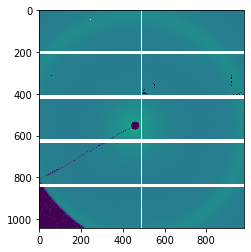

In [22]:
image = image / monitorI / acqTime / image_transmission
fig, ax = plt.subplots()
ax.imshow(image, norm=LogNorm())

In [23]:
image

array([[  27089.7178082 ,   63209.34155248,   63209.34155248, ...,
        3747410.96346828, 3648081.99817153, 3702261.43378794],
       [  36119.62374427,   81269.15342461,  171568.21278529, ...,
        3765470.77534041, 3666141.81004366, 3648081.99817153],
       [  27089.7178082 ,  117388.77716889,  198657.9305935 , ...,
        3819650.21095682, 3873829.64657323, 3738381.05753221],
       ...,
       [      0.        ,       0.        ,       0.        , ...,
        4397564.19086518, 4216966.07214382, 4262115.60182416],
       [      0.        ,       0.        ,       0.        , ...,
        4343384.75524878, 4830999.67579645, 4514952.96803407],
       [      0.        ,    9029.90593607,       0.        , ...,
        4731670.71049971, 5011597.79451782, 4153756.73059134]])